In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = '../input/stage1_train/'
TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:58<00:00,  5.63it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 66.23it/s]


Done!


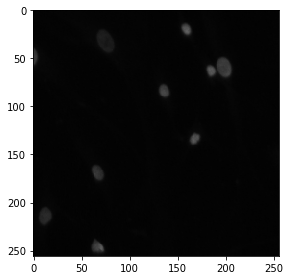

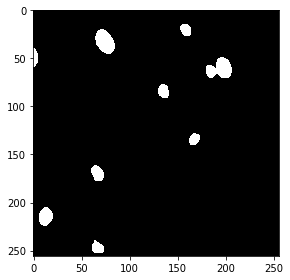

In [4]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [5]:
X_train.shape, Y_train.shape

((670, 256, 256, 3), (670, 256, 256, 1))

In [6]:
X_train[ix].shape, np.squeeze(Y_train[ix]).shape

((256, 256, 3), (256, 256))

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
____________________________________

__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 256, 256, 32) 0           conv2d_transpose_4[0][0]         
                                                                 conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 256, 256, 16) 4624        concatenate_4[0][0]              
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 16) 2320        dropout_9[0][0]                  
__________________________________________________________________________________________________
conv2d_19 

In [21]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.15, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

Train on 569 samples, validate on 101 samples
Epoch 1/100
569/569 [==============================] - 10s 18ms/step - loss: 0.0597 - mean_iou: 0.8586 - val_loss: 0.0617 - val_mean_iou: 0.8831
Epoch 2/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0589 - mean_iou: 0.8838 - val_loss: 0.0618 - val_mean_iou: 0.8832
Epoch 3/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0599 - mean_iou: 0.8821 - val_loss: 0.0649 - val_mean_iou: 0.8822
Epoch 4/100
569/569 [==============================] - 8s 13ms/step - loss: 0.0568 - mean_iou: 0.8826 - val_loss: 0.0618 - val_mean_iou: 0.8833
Epoch 5/100


569/569 [==============================] - 8s 14ms/step - loss: 0.0578 - mean_iou: 0.8838 - val_loss: 0.0607 - val_mean_iou: 0.8836
Epoch 6/100
569/569 [==============================] - 8s 13ms/step - loss: 0.0583 - mean_iou: 0.8843 - val_loss: 0.0649 - val_mean_iou: 0.8841
Epoch 7/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0552 - mean_iou: 0.8843 - val_loss: 0.0622 - val_mean_iou: 0.8849
Epoch 8/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0558 - mean_iou: 0.8852 - val_loss: 0.0625 - val_mean_iou: 0.8854
Epoch 9/100


569/569 [==============================] - 7s 13ms/step - loss: 0.0543 - mean_iou: 0.8858 - val_loss: 0.0612 - val_mean_iou: 0.8860
Epoch 10/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0547 - mean_iou: 0.8861 - val_loss: 0.0658 - val_mean_iou: 0.8865
Epoch 11/100
569/569 [==============================] - 8s 14ms/step - loss: 0.0524 - mean_iou: 0.8866 - val_loss: 0.0603 - val_mean_iou: 0.8872
Epoch 12/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0522 - mean_iou: 0.8875 - val_loss: 0.0636 - val_mean_iou: 0.8879
Epoch 13/100


569/569 [==============================] - 7s 13ms/step - loss: 0.0520 - mean_iou: 0.8882 - val_loss: 0.0652 - val_mean_iou: 0.8885
Epoch 14/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0515 - mean_iou: 0.8887 - val_loss: 0.0668 - val_mean_iou: 0.8890
Epoch 15/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0490 - mean_iou: 0.8893 - val_loss: 0.0666 - val_mean_iou: 0.8896
Epoch 16/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0511 - mean_iou: 0.8899 - val_loss: 0.0651 - val_mean_iou: 0.8901
Epoch 17/100


569/569 [==============================] - 7s 13ms/step - loss: 0.0491 - mean_iou: 0.8904 - val_loss: 0.0631 - val_mean_iou: 0.8908
Epoch 18/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0464 - mean_iou: 0.8911 - val_loss: 0.0671 - val_mean_iou: 0.8915
Epoch 19/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0463 - mean_iou: 0.8919 - val_loss: 0.0660 - val_mean_iou: 0.8923
Epoch 20/100
569/569 [==============================] - 7s 13ms/step - loss: 0.0458 - mean_iou: 0.8926 - val_loss: 0.0638 - val_mean_iou: 0.8929
Epoch 21/100


569/569 [==============================] - 8s 13ms/step - loss: 0.0468 - mean_iou: 0.8932 - val_loss: 0.0772 - val_mean_iou: 0.8934
Epoch 00021: early stopping


In [22]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 0s 3ms/step


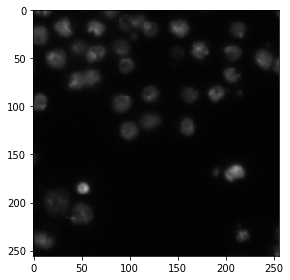

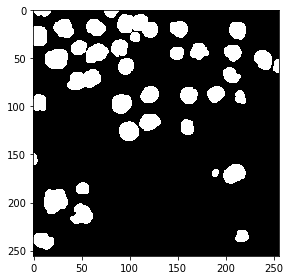

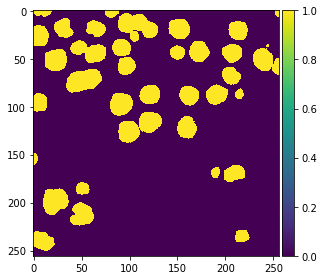

In [23]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [24]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [25]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [26]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)